In [170]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np

In [171]:
product_info_file_path = '../data/product_info.csv'
data = pd.read_csv(product_info_file_path)
data_info = data.info()
# data_head = data.head()
# data_info, data_head
print(data.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8494 entries, 0 to 8493
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_id          8494 non-null   object 
 1   product_name        8494 non-null   object 
 2   brand_id            8494 non-null   int64  
 3   brand_name          8494 non-null   object 
 4   loves_count         8494 non-null   int64  
 5   rating              8216 non-null   float64
 6   reviews             8216 non-null   float64
 7   size                6863 non-null   object 
 8   variation_type      7050 non-null   object 
 9   variation_value     6896 non-null   object 
 10  variation_desc      1250 non-null   object 
 11  ingredients         7549 non-null   object 
 12  price_usd           8494 non-null   float64
 13  value_price_usd     451 non-null    float64
 14  sale_price_usd      270 non-null    float64
 15  limited_edition     8494 non-null   int64  
 16  new   

In [172]:
product_info_df = data.copy()
product_info_df = product_info_df[product_info_df['primary_category'].isin( ['Bath & Body', 'Hair', 'Makeup', 'Skincare'])]


product_info_df.drop(['product_id', 'brand_id'], axis=1, inplace=True)
# product_info_df.rename(columns={'rating': 'overall_rating'}, inplace=True)

# 1. Handle Missing Values
# For numerical columns (e.g., 'rating', 'reviews'), impute with median
numerical_cols = product_info_df.select_dtypes(include=['float64', 'int64']).columns
print(numerical_cols)
num_imputer = SimpleImputer(strategy='median')
product_info_df[numerical_cols] = num_imputer.fit_transform(product_info_df[numerical_cols])
print(product_info_df.isnull().sum())


Index(['loves_count', 'rating', 'reviews', 'price_usd', 'value_price_usd',
       'sale_price_usd', 'limited_edition', 'new', 'online_only',
       'out_of_stock', 'sephora_exclusive', 'child_count', 'child_max_price',
       'child_min_price'],
      dtype='object')
product_name             0
brand_name               0
loves_count              0
rating                   0
reviews                  0
size                  1364
variation_type        1171
variation_value       1312
variation_desc        5447
ingredients            691
price_usd                0
value_price_usd          0
sale_price_usd           0
limited_edition          0
new                      0
online_only              0
out_of_stock             0
sephora_exclusive        0
highlights            1529
primary_category         0
secondary_category       0
tertiary_category      680
child_count              0
child_max_price          0
child_min_price          0
dtype: int64


Index(['product_name', 'brand_name', 'loves_count', 'rating', 'reviews',
       'size', 'variation_type', 'variation_value', 'variation_desc',
       'price_usd', 'value_price_usd', 'sale_price_usd', 'limited_edition',
       'new', 'online_only', 'out_of_stock', 'sephora_exclusive',
       'primary_category', 'secondary_category', 'tertiary_category',
       'child_count', 'child_max_price', 'child_min_price'],
      dtype='object')
Highly correlated pairs:  [('loves_count', 'reviews'), ('child_max_price', 'child_min_price')]


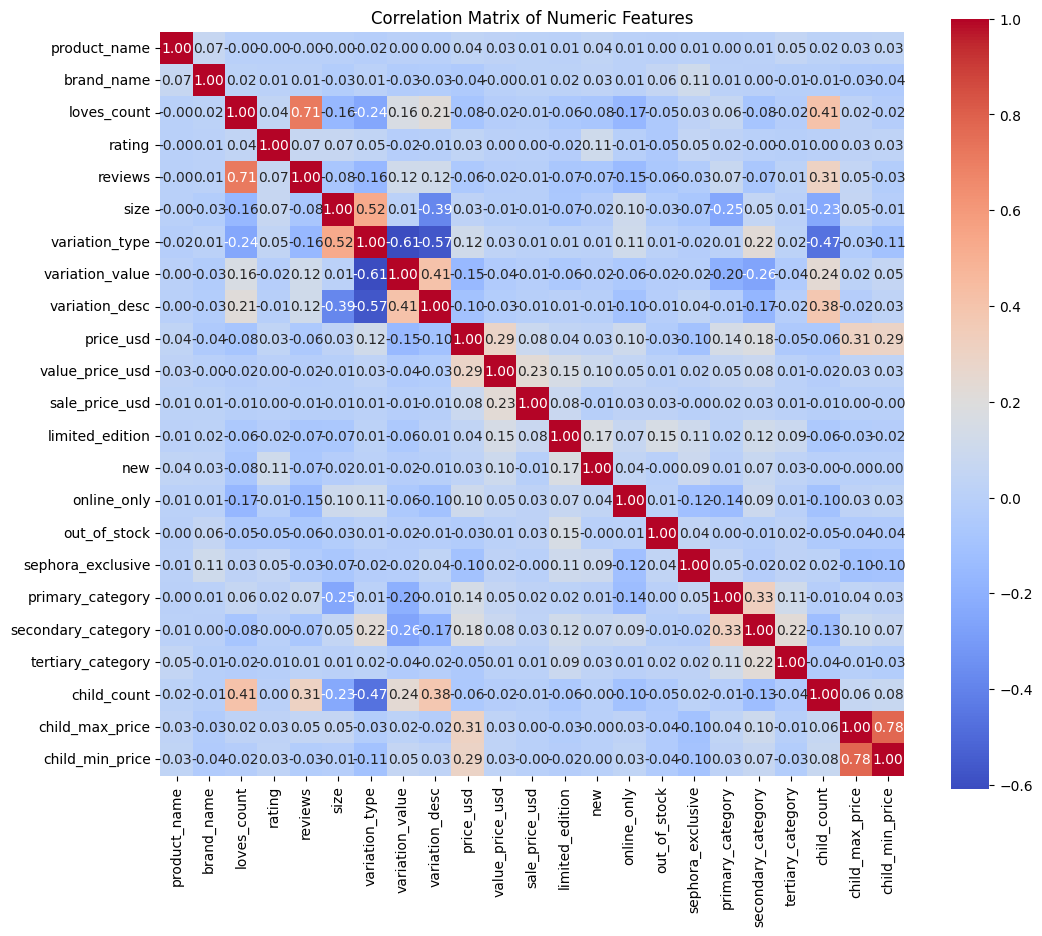

In [182]:
# print(product_info_df.info())
corr_matrix_threshold = 0.7
numerical_cols = product_info_df.select_dtypes(include=['float64', 'int64']).columns
print(numerical_cols)
correlation_matrix = product_info_df[numerical_cols].corr()
high_corr_pairs = list(correlation_matrix[abs(correlation_matrix) >= corr_matrix_threshold].where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)).stack().index)
print("Highly correlated pairs: ", high_corr_pairs)

# Visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

In [174]:
# For categorical columns (e.g., 'size', 'variation_type'), impute with most frequent
categorical_cols = ['size', 'variation_type', 'variation_value','variation_desc', 'tertiary_category']
cat_imputer = SimpleImputer(strategy='most_frequent')
product_info_df[categorical_cols] = cat_imputer.fit_transform(product_info_df[categorical_cols])


In [175]:
# Encoding binary categorical columns
binary_cols = ['limited_edition', 'new', 'online_only', 'out_of_stock', 'sephora_exclusive']
product_info_df[binary_cols] = product_info_df[binary_cols].astype(int)

In [176]:
# Encoding specific categorical columns with Label Encoding
label_encoder_cols = ['brand_name', 'product_name', 'primary_category', 'secondary_category', 'tertiary_category', 'size', 'variation_type', 'variation_value','variation_desc']
label_encoders = {col: LabelEncoder() for col in label_encoder_cols}
for col in label_encoder_cols:
    product_info_df[col] = label_encoders[col].fit_transform(product_info_df[col].astype(str))


In [177]:
product_info_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6658 entries, 14 to 8493
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_name        6658 non-null   int64  
 1   brand_name          6658 non-null   int64  
 2   loves_count         6658 non-null   float64
 3   rating              6658 non-null   float64
 4   reviews             6658 non-null   float64
 5   size                6658 non-null   int64  
 6   variation_type      6658 non-null   int64  
 7   variation_value     6658 non-null   int64  
 8   variation_desc      6658 non-null   int64  
 9   ingredients         5967 non-null   object 
 10  price_usd           6658 non-null   float64
 11  value_price_usd     6658 non-null   float64
 12  sale_price_usd      6658 non-null   float64
 13  limited_edition     6658 non-null   int64  
 14  new                 6658 non-null   int64  
 15  online_only         6658 non-null   int64  
 16  out_of_sto

Index(['product_name', 'brand_name', 'loves_count', 'rating', 'reviews',
       'size', 'variation_type', 'variation_value', 'variation_desc',
       'price_usd', 'value_price_usd', 'sale_price_usd', 'limited_edition',
       'new', 'online_only', 'out_of_stock', 'sephora_exclusive',
       'primary_category', 'secondary_category', 'tertiary_category',
       'child_count', 'child_max_price', 'child_min_price'],
      dtype='object')
Highly correlated pairs:  [('loves_count', 'reviews'), ('child_max_price', 'child_min_price')]


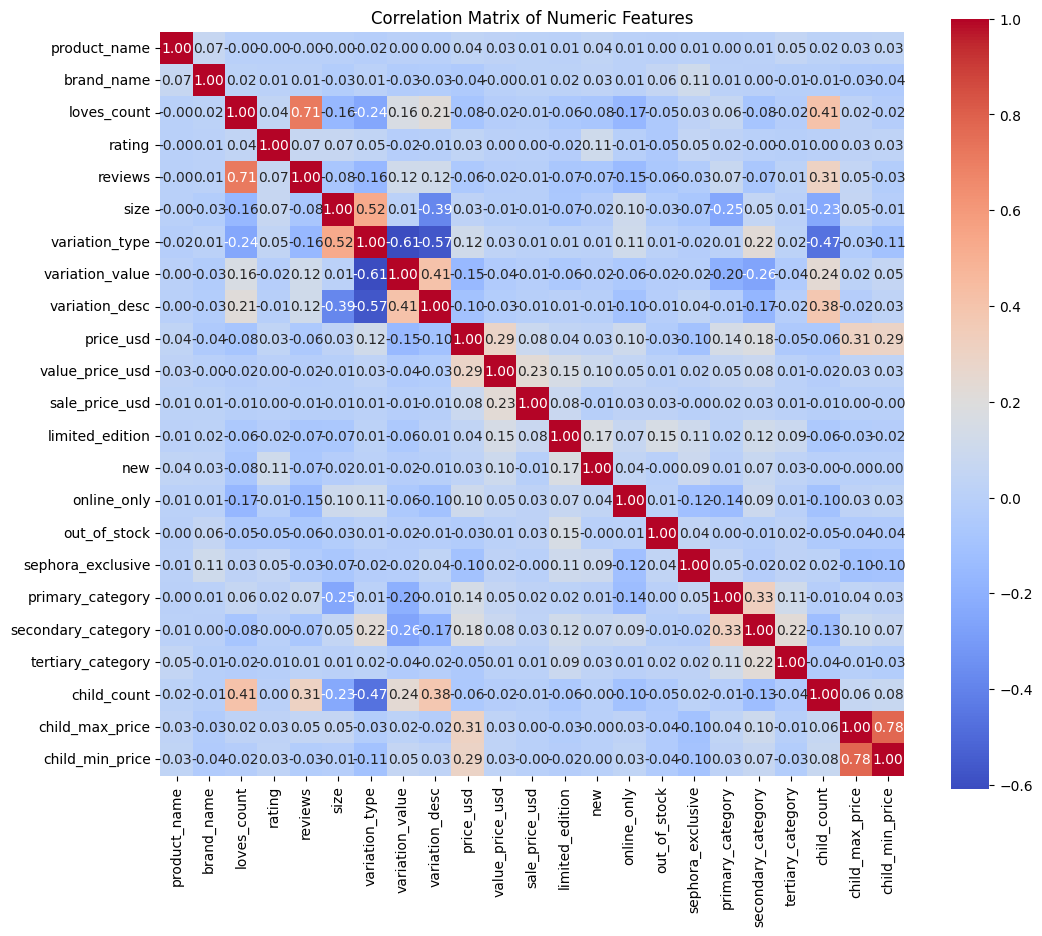

,product_name,brand_name,loves_count,rating,reviews,size,variation_type,variation_value,variation_desc,price_usd,...,new,online_only,out_of_stock,sephora_exclusive,primary_category,secondary_category,tertiary_category,child_count,child_max_price,child_min_price
product_name,1.000000,0.067773,-0.002772,-0.002802,-0.000883,-0.001757,-0.017536,0.003811,0.000312,0.036755,...,0.037181,0.010846,0.004667,0.011015,0.002266,0.009687,0.049552,0.015473,0.026522,0.032929
brand_name,0.067773,1.000000,0.015068,0.010603,0.012894,-0.027326,0.013767,-0.032840,-0.029820,-0.043156,...,0.027141,0.013196,0.056329,0.114046,0.012499,0.002564,-0.007892,-0.005350,-0.034594,-0.039337
loves_count,-0.002772,0.015068,1.000000,0.044424,0.711880,-0.156821,-0.244066,0.163751,0.208933,-0.083917,...,-0.076686,-0.166801,-0.051746,0.025269,0.062315,-0.084137,-0.018230,0.406116,0.020205,-0.018371
rating,-0.002802,0.010603,0.044424,1.000000,0.068997,0.069760,0.045085,-0.015323,-0.008827,0.033483,...,0.109312,-0.007982,-0.053299,0.050093,0.023643,-0.000443,-0.009861,0.002915,0.025839,0.031865
reviews,-0.000883,0.012894,0.711880,0.068997,1.000000,-0.075463,-0.155889,0.118198,0.117938,-0.055959,...,-0.067225,-0.145127,-0.062681,-0.033872,0.074006,-0.072717,0.014510,0.307857,0.049096,-0.027679
size,-0.001757,-0.027326,-0.156821,0.069760,-0.075463,1.000000,0.524818,0.010149,-0.387729,0.025641,...,-0.022687,0.102405,-0.029311,-0.070832,-0.248523,0.046600,0.005631,-0.234971,0.054715,-0.013124
variation_type,-0.017536,0.013767,-0.244066,0.045085,-0.155889,0.524818,1.000000,-0.607998,-0.567045,0.117482,...,0.010232,0.111646,0.013625,-0.022179,0.007840,0.222457,0.018470,-0.465669,-0.025337,-0.105301
variation_value,0.003811,-0.032840,0.163751,-0.015323,0.118198,0.010149,-0.607998,1.000000,0.409223,-0.152963,...,-0.022579,-0.060286,-0.018941,-0.017203,-0.203160,-0.261576,-0.040410,0.238090,0.016158,0.052551
variation_desc,0.000312,-0.029820,0.208933,-0.008827,0.117938,-0.387729,-0.567045,0.409223,1.000000,-0.104344,...,-0.008055,-0.101500,-0.012976,0.036904,-0.011898,-0.171154,-0.016251,0.380865,-0.019534,0.030594
price_usd,0.036755,-0.043156,-0.083917,0.033483,-0.055959,0.025641,0.117482,-0.152963,-0.104344,1.000000,...,0.028470,0.104957,-0.032845,-0.101553,0.143825,0.183322,-0.054906,-0.060961,0.306639,0.291593


In [ ]:
# print(product_info_df.info())
corr_matrix_threshold = 0.7
numerical_cols = product_info_df.select_dtypes(include=['float64', 'int64']).columns
print(numerical_cols)
correlation_matrix = product_info_df[numerical_cols].corr()
high_corr_pairs = list(correlation_matrix[abs(correlation_matrix) >= corr_matrix_threshold].where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)).stack().index)
print("Highly correlated pairs: ", high_corr_pairs)

# Visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

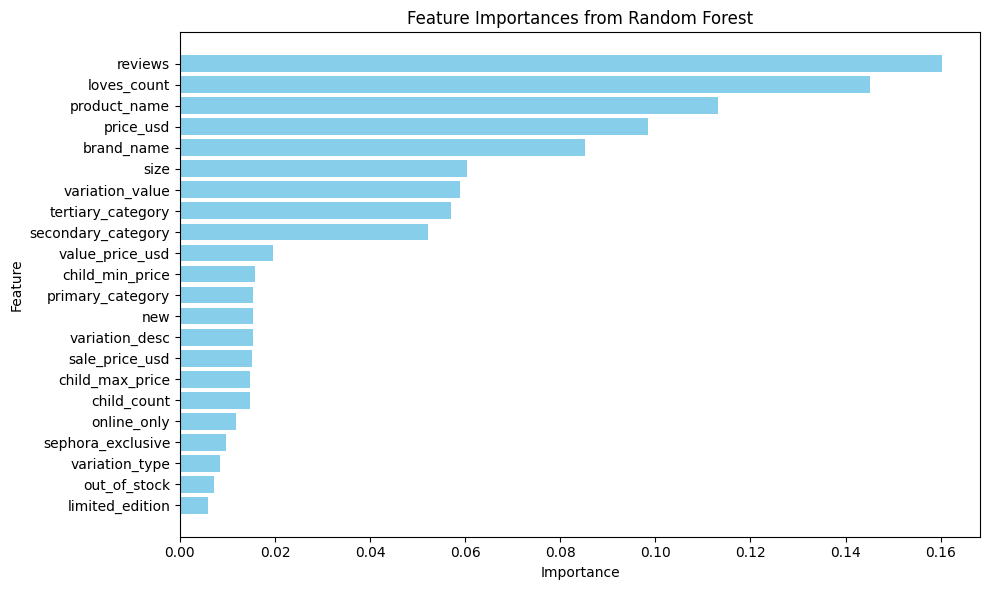

In [179]:
# Selecting numeric features (excluding the target 'rating')
target_variable = 'rating'
features = numerical_cols.drop(target_variable)
X = product_info_df[features]
y = product_info_df[target_variable]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X_train_scaled, y_train)

# Extract feature importances
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display the feature importance table using matplotlib for visualization
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()